# Explore data `slack_1`

In [1]:
from pathlib import Path
import pandas as pd
from typing import List

import NegativeClassOptimization.utils as utils
import NegativeClassOptimization.config as config

In [2]:
df_files = utils.summarize_data_files(config.DATA_SLACK_1_RAW_DIR).sort_values(["filetype", "antigen"])
df_files

,filepath,filename,filetype,antigen,datatype
8,/data/sources/eugen/negative-class-optimizatio...,1ADQ_top_70000_corpus.csv,csv,1ADQ,corpus
9,/data/sources/eugen/negative-class-optimizatio...,1FBI_top_70000_corpus.csv,csv,1FBI,corpus
5,/data/sources/eugen/negative-class-optimizatio...,1H0D_top_70000_corpus.csv,csv,1H0D,corpus
14,/data/sources/eugen/negative-class-optimizatio...,1NSN_top_70000_corpus.csv,csv,1NSN,corpus
12,/data/sources/eugen/negative-class-optimizatio...,1OB1_top_70000_corpus.csv,csv,1OB1,corpus
16,/data/sources/eugen/negative-class-optimizatio...,1WEJ_top_70000_corpus.csv,csv,1WEJ,corpus
10,/data/sources/eugen/negative-class-optimizatio...,2YPV_top_70000_corpus.csv,csv,2YPV,corpus
2,/data/sources/eugen/negative-class-optimizatio...,3RAJ_top_70000_corpus.csv,csv,3RAJ,corpus
0,/data/sources/eugen/negative-class-optimizatio...,3VRL_top_70000_corpus.csv,csv,3VRL,corpus
4,/data/sources/eugen/negative-class-optimizatio...,5E94_top_70000_corpus.csv,csv,5E94,corpus


## File format

It looks like `features` files have more annotations for the data in `corpus` files.

In [3]:
ag_data = utils.AntigenData("3VRL", config.DATA_SLACK_1_RAW_DIR)
ag_data.df_c.head(2)

,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,UID
0,1873658_06a,CARPENLLLLLWYFDVW,True,LLLLLWYFDVW,-112.82,137442-BRDSLLUDLS,3VRL_1873658_06a
1,7116990_04a,CARGLLLLLWYFDVW,True,LLLLLWYFDVW,-112.82,137442-BRDSLLUDLS,3VRL_7116990_04a


## Fetch global dataset from all antigens

In [4]:
df_global = utils.load_global_dataframe()
df_global

,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,UID,Antigen
0,5319791_04a,CARSAAFITTVGWYFDVW,True,AAFITTVGWYF,-94.70,128933-BRRSLUDUUS,1ADQ_5319791_04a,1ADQ
1,3796836_02a,CAAAFYGRWYFDVW,True,AAFYGRWYFDV,-94.57,128933-BRRSLUSURD,1ADQ_3796836_02a,1ADQ
2,5098589_01a,CAAFYYGNLAWFAYW,True,AAFYYGNLAWF,-97.63,141287-DDLUSURLRR,1ADQ_5098589_01a,1ADQ
3,5151925_01a,CAAGWLLLFAYW,True,AAGWLLLFAYW,-95.45,124837-RRURSUUSLD,1ADQ_5151925_01a,1ADQ
4,879141_05a,CARYAAAGWLLLFDYW,True,AAGWLLLFDYW,-95.45,124837-RRURSUUSLD,1ADQ_879141_05a,1ADQ
...,...,...,...,...,...,...,...,...
460478,6936432_06a,CTTEGSYYYFFGVFAYW,True,YYYFFGVFAYW,-99.77,157601-SDSRSDRLLR,5E94_6936432_06a,5E94
460479,2128564_06a,CARAPYYYYVSSYLFVW,True,YYYVSSYLFVW,-98.25,157601-SDSRSDRLLR,5E94_2128564_06a,5E94
460480,2106520_04a,CARSYYYYGSILFAYW,True,YYYYGSILFAY,-97.16,157601-SDSRSDRLLR,5E94_2106520_04a,5E94
460481,3264501_03a,CARYYYYGSSFFYFDYW,True,YYYYGSSFFYF,-97.65,157601-SDSRSDRLLR,5E94_3264501_03a,5E94


In [5]:
cdr3_lengths = df_global["CDR3"].str.len().value_counts()
cdr3_lengths = cdr3_lengths / cdr3_lengths.sum()
# cdr3_lengths.to_dict()  # record to config
cdr3_lengths

14    0.219142
15    0.175116
16    0.145462
17    0.102312
13    0.093335
12    0.074691
11    0.067979
18    0.063043
19    0.033152
20    0.014654
21    0.006319
22    0.002706
23    0.001138
24    0.000441
25    0.000159
26    0.000104
28    0.000076
27    0.000067
31    0.000026
36    0.000017
30    0.000015
40    0.000011
29    0.000007
39    0.000007
33    0.000004
43    0.000004
35    0.000004
37    0.000004
34    0.000002
32    0.000002
Name: CDR3, dtype: float64

How unique are the CDR3s in the dataset?

- it looks like a lot of redundant CDR3, mainly **between**, not within, different antibodies.

In [6]:
cdr3_uniq = df_global["CDR3"].unique()
print(f"CDR3 unique shape: {cdr3_uniq.shape}\nValue counts:")
df_global["CDR3"].value_counts()

CDR3 unique shape: (290050,)
Value counts:


CAGDNLLPYLIVTLPFAYW    10
CARGFLRLLLRWYFDVW      10
CAREGQLWLYLAWFAYW      10
CTVLLLWLRLFDYW         10
CARSFLLRYPLLYFDVW      10
                       ..
CARYGFAWFAYW            1
CARYGGSLGWFAYW          1
CARYGHQLRVFDYW          1
CARYGIGWFAYW            1
CARYYYYGSSFFYFDYW       1
Name: CDR3, Length: 290050, dtype: int64

## Duplicated `Slide` sequences

We want to have a better way to handle duplicated `Slide` sequnces. For that, we generate a processed version of the global dataset where we aggregate by Slide and keep track of duplication explicitely.

In [7]:
# 1. Remove duplicated Slide that bind the same Antigen
df_global = df_global.groupby("Antigen").apply(
    lambda df_: df_
    .sort_values(["Slide", "Energy"], ascending=True)
    .drop_duplicates("Slide", keep="first")
    ).reset_index(drop=True)
df_global

,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,UID,Antigen
0,5319791_04a,CARSAAFITTVGWYFDVW,True,AAFITTVGWYF,-94.70,128933-BRRSLUDUUS,1ADQ_5319791_04a,1ADQ
1,3796836_02a,CAAAFYGRWYFDVW,True,AAFYGRWYFDV,-94.57,128933-BRRSLUSURD,1ADQ_3796836_02a,1ADQ
2,5098589_01a,CAAFYYGNLAWFAYW,True,AAFYYGNLAWF,-97.63,141287-DDLUSURLRR,1ADQ_5098589_01a,1ADQ
3,5151925_01a,CAAGWLLLFAYW,True,AAGWLLLFAYW,-95.45,124837-RRURSUUSLD,1ADQ_5151925_01a,1ADQ
4,879141_05a,CARYAAAGWLLLFDYW,True,AAGWLLLFDYW,-95.45,124837-RRURSUUSLD,1ADQ_879141_05a,1ADQ
...,...,...,...,...,...,...,...,...
460478,6936432_06a,CTTEGSYYYFFGVFAYW,True,YYYFFGVFAYW,-99.77,157601-SDSRSDRLLR,5E94_6936432_06a,5E94
460479,2128564_06a,CARAPYYYYVSSYLFVW,True,YYYVSSYLFVW,-98.25,157601-SDSRSDRLLR,5E94_2128564_06a,5E94
460480,2106520_04a,CARSYYYYGSILFAYW,True,YYYYGSILFAY,-97.16,157601-SDSRSDRLLR,5E94_2106520_04a,5E94
460481,3264501_03a,CARYYYYGSSFFYFDYW,True,YYYYGSSFFYF,-97.65,157601-SDSRSDRLLR,5E94_3264501_03a,5E94


In [8]:
df_global_slide_agg = pd.DataFrame(
    df_global.groupby("Slide")["Antigen"]
    .agg(
        antigens=lambda s: "_".join(sorted(s.values.tolist())),
        num_antigens=lambda s: len(s.values.tolist()),
    )
    ).sort_values("num_antigens", ascending=False).reset_index()
df_global_slide_agg

,Slide,antigens,num_antigens
0,FLLLLRFNWYF,1FBI_1NSN_1OB1_1WEJ_2YPV_3RAJ_3VRL_5E94,8
1,GLLLLPLVFVW,1ADQ_1NSN_1OB1_1WEJ_2YPV_3RAJ_3VRL_5E94,8
2,FLLLLGYFDVW,1ADQ_1FBI_1NSN_1WEJ_2YPV_3RAJ_3VRL_5E94,8
3,LLVLLLLRWVF,1ADQ_1FBI_1H0D_1OB1_1WEJ_2YPV_3RAJ_3VRL,8
4,ILALLRYGWYF,1FBI_1NSN_1WEJ_2YPV_3RAJ_3VRL_5E94,7
...,...,...,...
369382,DIGNFYYFDYW,1WEJ,1
369383,DIGLYYYDWYF,2YPV,1
369384,DIGLYDYFDYW,2YPV,1
369385,DIGLRILFDYW,3VRL,1


<AxesSubplot:>

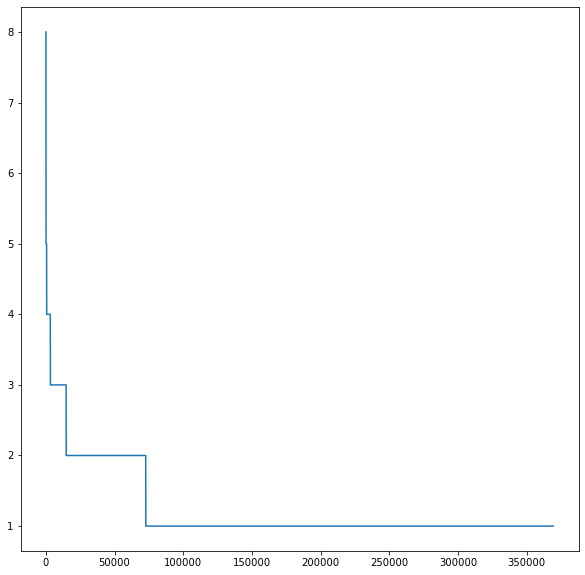

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
df_global_slide_agg["num_antigens"].plot(ax=ax)
# ax.set_xlim((0, 10000))

## Data splits for open set experiments.

In this section we evaluate splitting strategies for data splitting reproducibility.

We need an open exclusive set, i.e. an open set which doesn't share `Slide` with any potential closed set. We can reliably build such a set with losing about 25% of `Slide` sequences. Building this during the runtime of each open set problem is possible, might have lower losses of data (not immediately clear how large), but increases data management and reproducibility complexity significantly, an unjustifiable cost at this point.

In [10]:
df = df_global

mask_ = df["Antigen"].isin(config.ANTIGENS_OPENSET)
df_closed = df.loc[~mask_].copy()
df_open = df.loc[mask_].copy()
df_open_exclusive = df_open.loc[~df_open["Slide"].isin(df_closed["Slide"])].copy()

print(f"""
    closed: 
{df_closed["Slide"].describe()}
    
    open: 
{df_open["Slide"].describe()}
    
    open_exclusive: 
{df_open_exclusive["Slide"].describe()}
""")


    closed: 
count          272307
unique         238104
top       FLPLLLLRFYY
freq                6
Name: Slide, dtype: object
    
    open: 
count          188176
unique         172319
top       IVPLYDYPFAM
freq                4
Name: Slide, dtype: object
    
    open_exclusive: 
count          140979
unique         131283
top       ELWLLRYYYAM
freq                4
Name: Slide, dtype: object



In [11]:
df_closed["Slide"]

,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,UID,Antigen
41349,4067765_05a,CARRGAALRLVWFAYW,True,AALRLVWFAYW,-90.85,153506-SLRDRLSLDR,1FBI_4067765_05a,1FBI
41350,4414492_01a,CACEILRWGVYFDYW,True,ACEILRWGVYF,-90.31,137187-UDRUSUDRDU,1FBI_4414492_01a,1FBI
41351,6222083_01a,CACFLITADWYFDVW,True,ACFLITADWYF,-91.08,137187-UDRUSUDRDU,1FBI_6222083_01a,1FBI
41352,2478233_01a,CACGLLWLRWYFDVW,True,ACGLLWLRWYF,-97.08,137187-UDRUSUDRDU,1FBI_2478233_01a,1FBI
41353,2857381_01a,CACHYVQLNWYFDVW,True,ACHYVQLNWYF,-91.95,137187-UDRUSUDRDU,1FBI_2857381_01a,1FBI
...,...,...,...,...,...,...,...,...
460478,6936432_06a,CTTEGSYYYFFGVFAYW,True,YYYFFGVFAYW,-99.77,157601-SDSRSDRLLR,5E94_6936432_06a,5E94
460479,2128564_06a,CARAPYYYYVSSYLFVW,True,YYYVSSYLFVW,-98.25,157601-SDSRSDRLLR,5E94_2128564_06a,5E94
460480,2106520_04a,CARSYYYYGSILFAYW,True,YYYYGSILFAY,-97.16,157601-SDSRSDRLLR,5E94_2106520_04a,5E94
460481,3264501_03a,CARYYYYGSSFFYFDYW,True,YYYYGSSFFYF,-97.65,157601-SDSRSDRLLR,5E94_3264501_03a,5E94
